### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='left').fillna(1)
    return df#.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def target_encoding(df):
    enc = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        enc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
    df['target_mean_enc'] = enc
    return df

def generate_feature_seconds(features, df, feats, seconds=[300]):
    for second in seconds:
        res = pd.DataFrame(
            df.query(f'{300-second} <= seconds_in_bucket < {seconds[0]}')
            .groupby(['time_id']).agg(feats)
        ).reset_index()
        res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
        res = res.add_suffix('_' + str(second))
        features = pd.merge(
            features, res, 
            how='left', 
            left_on='time_id', 
            right_on=f'time_id_{second}'
        )
        features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d


def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"individual_book_train/stock_{stock_id}.csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(target_encoding(pd.concat(df, ignore_index = True)))

def generate_features(file_path):
    df = pd.read_csv(file_path)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)
    
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean],#, mad, np.max, np.sum],
        'wap2':[np.mean],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, mad, np.max, np.sum],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, mad, np.max, np.sum],
        'wap_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff':[np.mean],#, mad, np.max, np.sum],
        'price_diff2':[np.mean],#, mad, np.max, np.sum],
        'bid_diff':[np.mean],#, mad, np.max, np.sum],
        'ask_diff':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean],#, mad, np.max, np.sum],
        'dom':[np.mean],#, mad, np.max, np.sum],
        'dom_diff':[np.mean],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean],#, mad, np.max, np.sum],
        'slope':[np.mean],#, mad, np.max, np.sum],
        'dispersion':[np.mean],#, mad, np.max, np.sum],
        'price_impact':[np.mean],#, mad, np.max, np.sum],
        'ofi':[np.mean],#, mad, np.max, np.sum],
        'turn_over':[np.mean]#, mad, np.max, np.sum],
    }
  
    
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[300]  # features generated for each second interval (different widths)
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

b = process_stocks([0, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.0s finished


In [4]:
b

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,5,0.002954,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002961,1.208072,313.922175,0.000865
1,11,0.000981,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002997,1.719756,380.683774,0.000432
2,16,0.001295,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002982,7.164047,417.199888,0.000733
3,31,0.001776,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002982,6.559597,465.014775,0.000898
4,62,0.001520,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002962,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,32751,0.002212,1.000155,1.000018,0.002995,0.000173,3.013173e-10,-3.739256e-06,0.000076,0.000782,...,262353.682815,0.000184,-0.000091,-0.326667,26.447079,1,0.003233,0.225453,285.711186,0.000602
7656,32753,0.008499,1.003102,1.002956,0.006710,0.000388,2.461446e-08,5.595932e-05,0.000209,0.003866,...,201255.340990,0.000256,-0.000077,19.440000,-46.340728,1,0.003229,28.996320,568.986705,0.000928
7657,32758,0.002108,1.000470,1.000498,0.002320,0.000134,1.159275e-10,3.521505e-06,0.000056,0.000570,...,54478.203076,0.000231,-0.000063,3.310000,29.405633,1,0.003224,1.602334,429.906110,0.000654
7658,32763,0.002728,1.001599,1.001610,0.002573,0.000149,1.184751e-10,1.334694e-05,0.000087,0.000798,...,25486.478966,0.000216,-0.000103,13.496667,-17.196034,1,0.003225,3.980220,523.056313,0.000418


## Process Features for All Stocks

In [5]:
all_stocks = process_stocks(pd.read_csv("all_times.csv").stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.8min finished


,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,5,0.002954,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002943,1.208072,313.922175,0.000865
1,11,0.000981,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002974,1.719756,380.683774,0.000432
2,16,0.001295,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002985,7.164047,417.199888,0.000733
3,31,0.001776,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002974,6.559597,465.014775,0.000898
4,62,0.001520,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002974,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999751,0.999942,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.000052,0.000782,...,49495.443105,0.000317,-0.000089,4.236667,-102.382279,126,0.003887,0.895436,418.205006,0.000870
428928,32753,0.003454,1.001470,1.001513,0.002217,0.000128,9.484441e-11,3.674218e-06,0.000052,0.000569,...,211041.684369,0.000245,-0.000047,3.150000,-28.969928,126,0.003887,-1.346971,222.682585,0.000670
428929,32758,0.002792,1.000656,1.000586,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.000022,0.000443,...,80550.060573,0.000263,-0.000110,2.726667,-37.164464,126,0.003904,0.904714,346.025217,0.000754
428930,32763,0.002379,1.001787,1.001794,0.002783,0.000161,1.960849e-10,6.737309e-06,0.000085,0.000887,...,95588.192176,0.000223,-0.000061,-2.323333,-34.701799,126,0.003904,-0.099107,438.588531,0.000526


### Defining X for LightGBM

In [6]:
all_stocks_X = all_stocks.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
#all_stocks_X.iloc[:,:] = MinMaxScaler().fit(all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,log_returns_sum_300,log_returns2_realized_volatility_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,0.002134,0.005032,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002943,1.208072,313.922175,0.000865
1,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,0.000264,0.001448,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002974,1.719756,380.683774,0.000432
2,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,0.000517,0.003583,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002985,7.164047,417.199888,0.000733
3,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,-0.001649,0.002422,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002974,6.559597,465.014775,0.000898
4,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,-0.000647,0.002412,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002974,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.999751,0.999942,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.000052,0.000782,-0.000855,0.004503,...,49495.443105,0.000317,-0.000089,4.236667,-102.382279,126,0.003887,0.895436,418.205006,0.000870
428928,1.001470,1.001513,0.002217,0.000128,9.484441e-11,3.674218e-06,0.000052,0.000569,0.001099,0.003652,...,211041.684369,0.000245,-0.000047,3.150000,-28.969928,126,0.003887,-1.346971,222.682585,0.000670
428929,1.000656,1.000586,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.000022,0.000443,-0.000729,0.002686,...,80550.060573,0.000263,-0.000110,2.726667,-37.164464,126,0.003904,0.904714,346.025217,0.000754
428930,1.001787,1.001794,0.002783,0.000161,1.960849e-10,6.737309e-06,0.000085,0.000887,0.002014,0.004316,...,95588.192176,0.000223,-0.000061,-2.323333,-34.701799,126,0.003904,-0.099107,438.588531,0.000526


### Defining y for LightGBM

In [7]:
all_stocks_y = all_stocks[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

In [8]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428927,0.002899,126,32751
428928,0.003454,126,32753
428929,0.002792,126,32758
428930,0.002379,126,32763


In [9]:
len(pd.read_csv("all_times.csv").time_id.unique())

3454

Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [10]:
EPSILON = 1e-10

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')

def plot_importance(importance, title='', save_to_file=None):
    fig, ax = plt.subplots(figsize=(8, 12))
    importance.plot.barh(ax=ax)
    if title: plt.title(title)
    plt.tight_layout()
    do = plt.savefig(save_to_file) if save_to_file else plt.show()
    plt.close()
    
def compute_mean_importance(importance):
    res = importance[0].copy()
    res['importance'] = np.mean(
        np.array([df['importance'].values for df in importance]), 
        axis=0
    )
    return res
    
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

### Nested 5-Fold Cross-Validation

In [11]:
%%time
test = pd.DataFrame({'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]})
all_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

seed = 42

# some params taken from research paper (link @ bottom of notebook)
params = {
    "objective": "regression",
    "metric": "rmse", 
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,  
    "bagging_fraction": 0.8,
    "learning_rate": 0.05,
    #"lambda_l1": 1,
    #"lambda_l2": 1,
    #"early_stopping_rounds": 100,
    "lambda_l1": 2,
    "lambda_l2": 4,
    "extra_trees": True,
    "force_col_wise": True,
  }


outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
    
        lgbm_train = lgbm.Dataset(
            X_inner_train, 
            y_inner_train, 
            weight = 1 / (np.square(y_inner_train.values)+EPSILON)         # weighting rmspe
        )
        lgbm_valid = lgbm.Dataset(
            X_inner_valid, 
            y_inner_valid, 
            reference = lgbm_train, 
            weight = 1 / (np.square(y_inner_valid.values)+EPSILON)        # weighting rmspe
        )
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            early_stopping_rounds=100,
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred)
        )
        
        print("\t"+"*" * 100)
        print(f'\tInner Validation RMSPE: {RMSPE}')
        print("\t"+"*" * 100)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test, num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************



C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001181
[100]	training's rmse: 0.000357656	training's RMSPE: 0.24475	valid_1's rmse: 0.000961169	valid_1's RMSPE: 71004
	****************************************************************************************************
	Inner Validation RMSPE: 46831.63525299286
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001089
[100]	training's rmse: 0.000344893	training's RMSPE: 185.92	valid_1's rmse: 0.000377309	valid_1's RMSPE: 0.25549
[200]	training's rmse: 0.000332035	training's RMSPE: 10.3807	valid_1's rmse: 0.000368352	valid_1's

************************************************************************************************************************
Outer Fold : 2
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001194
[100]	training's rmse: 0.000358994	training's RMSPE: 0.24436	valid_1's rmse: 0.000959057	valid_1's RMSPE: 69972.8
	****************************************************************************************************
	Inner Validation RMSPE: 46127.84976529818
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of dat

[500]	training's rmse: 0.000315529	training's RMSPE: 1.13174	valid_1's rmse: 0.000344954	valid_1's RMSPE: 0.23309
[600]	training's rmse: 0.000312085	training's RMSPE: 2.0313	valid_1's rmse: 0.000342904	valid_1's RMSPE: 0.2317
[700]	training's rmse: 0.00030906	training's RMSPE: 1.99666	valid_1's rmse: 0.000341321	valid_1's RMSPE: 0.23064
[800]	training's rmse: 0.000306411	training's RMSPE: 3.51239	valid_1's rmse: 0.000339961	valid_1's RMSPE: 0.22972
[900]	training's rmse: 0.000303913	training's RMSPE: 0.67763	valid_1's rmse: 0.000339006	valid_1's RMSPE: 0.22907
[1000]	training's rmse: 0.000301792	training's RMSPE: 0.34171	valid_1's rmse: 0.000338106	valid_1's RMSPE: 0.22846
[1100]	training's rmse: 0.000299797	training's RMSPE: 0.50767	valid_1's rmse: 0.000337376	valid_1's RMSPE: 0.22797
[1200]	training's rmse: 0.000297933	training's RMSPE: 3.23499	valid_1's rmse: 0.000336616	valid_1's RMSPE: 0.22746
[1300]	training's rmse: 0.000296074	training's RMSPE: 5.55851	valid_1's rmse: 0.00033579

[100]	training's rmse: 0.000357036	training's RMSPE: 0.24498	valid_1's rmse: 0.000365421	valid_1's RMSPE: 0.24718
[200]	training's rmse: 0.000344457	training's RMSPE: 0.23635	valid_1's rmse: 0.000357062	valid_1's RMSPE: 0.24153
[300]	training's rmse: 0.000336178	training's RMSPE: 0.23066	valid_1's rmse: 0.00035133	valid_1's RMSPE: 0.23765
[400]	training's rmse: 0.000329862	training's RMSPE: 0.22633	valid_1's rmse: 0.00034755	valid_1's RMSPE: 0.2351
[500]	training's rmse: 0.00032495	training's RMSPE: 0.22296	valid_1's rmse: 0.000344804	valid_1's RMSPE: 0.23324
[600]	training's rmse: 0.000320824	training's RMSPE: 0.22013	valid_1's rmse: 0.000342476	valid_1's RMSPE: 0.23167
[700]	training's rmse: 0.000317581	training's RMSPE: 0.2179	valid_1's rmse: 0.000341241	valid_1's RMSPE: 0.23083
[800]	training's rmse: 0.000314681	training's RMSPE: 0.21591	valid_1's rmse: 0.000340127	valid_1's RMSPE: 0.23008
[900]	training's rmse: 0.000312185	training's RMSPE: 0.2142	valid_1's rmse: 0.000339116	valid

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274517, number of used features: 39
[LightGBM] [Info] Start training from score 0.001093
[100]	training's rmse: 0.000344601	training's RMSPE: 174.555	valid_1's rmse: 0.000376979	valid_1's RMSPE: 0.25567
[200]	training's rmse: 0.000332074	training's RMSPE: 8.65813	valid_1's rmse: 0.000367765	valid_1's RMSPE: 0.24943
[300]	training's rmse: 0.000324201	training's RMSPE: 24.8898	valid_1's rmse: 0.0003625	valid_1's RMSPE: 0.24586
[400]	training's rmse: 0.000318454	training's RMSPE: 6.14406	valid_1's rmse: 0.000358185	valid_1's RMSPE: 0.24293
[500]	training's rmse: 0.000314108	training's RMSPE: 6.68125	valid_1's rmse: 0.00035509	valid_1's RMSPE: 0.24083
[600]	training's rmse: 0.000310313	training's RMSPE: 9.71122	valid_1's rmse: 0.000353017	valid_1's RMSPE: 0.23943
[700]	training's rmse: 0.000307154	training's RMSPE: 12.3264	valid_1's rmse: 0.000351753	valid_1's RMSPE: 0.23857
[800]	training's rmse: 0

[1400]	training's rmse: 0.000292911	training's RMSPE: 0.99435	valid_1's rmse: 0.000340671	valid_1's RMSPE: 0.23145
[1500]	training's rmse: 0.000291393	training's RMSPE: 2.81278	valid_1's rmse: 0.00033988	valid_1's RMSPE: 0.23091
[1600]	training's rmse: 0.000289856	training's RMSPE: 8.1873	valid_1's rmse: 0.000339313	valid_1's RMSPE: 0.23053
[1700]	training's rmse: 0.00028852	training's RMSPE: 9.20952	valid_1's rmse: 0.000339013	valid_1's RMSPE: 0.23032
[1800]	training's rmse: 0.000287175	training's RMSPE: 7.078	valid_1's rmse: 0.000338596	valid_1's RMSPE: 0.23004
[1900]	training's rmse: 0.000285948	training's RMSPE: 8.28513	valid_1's rmse: 0.000338247	valid_1's RMSPE: 0.2298
[2000]	training's rmse: 0.000284783	training's RMSPE: 4.0176	valid_1's rmse: 0.000337925	valid_1's RMSPE: 0.22959
[2100]	training's rmse: 0.000283541	training's RMSPE: 0.28438	valid_1's rmse: 0.000337573	valid_1's RMSPE: 0.22935
[2200]	training's rmse: 0.000282468	training's RMSPE: 4.77523	valid_1's rmse: 0.0003372

[900]	training's rmse: 0.000302291	training's RMSPE: 0.49465	valid_1's rmse: 0.000342379	valid_1's RMSPE: 0.23275
[1000]	training's rmse: 0.000300147	training's RMSPE: 3.971	valid_1's rmse: 0.000341532	valid_1's RMSPE: 0.23218
[1100]	training's rmse: 0.000298174	training's RMSPE: 11.1166	valid_1's rmse: 0.00034076	valid_1's RMSPE: 0.23165
[1200]	training's rmse: 0.000296355	training's RMSPE: 1.07601	valid_1's rmse: 0.000340241	valid_1's RMSPE: 0.2313
[1300]	training's rmse: 0.000294506	training's RMSPE: 0.31395	valid_1's rmse: 0.000339909	valid_1's RMSPE: 0.23108
[1400]	training's rmse: 0.000292871	training's RMSPE: 9.16983	valid_1's rmse: 0.000339602	valid_1's RMSPE: 0.23087
[1500]	training's rmse: 0.00029137	training's RMSPE: 2.74534	valid_1's rmse: 0.000339375	valid_1's RMSPE: 0.23071
[1600]	training's rmse: 0.000289999	training's RMSPE: 7.41173	valid_1's rmse: 0.000339363	valid_1's RMSPE: 0.23071
	*************************************************************************************

### Training Validation Result with 5-fold CV

In [12]:
print(f'Train Result RMSPE: {np.mean(train_scores)}')

Train Result RMSPE: 7413.795102474702


In [13]:
train_scores

[9366.517615837722,
 9225.755062932,
 0.23567747162910443,
 9211.901821038044,
 9264.565335094112]

## NOTE: Problem with using RMSPE when actual value near zero

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [14]:
RMSPE = round(rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility']), 3)

print(f'Test Result RMSPE: {RMSPE}')

Test Result RMSPE: 28919.321


In [25]:
def rmse(targets, predictions):
    return np.sqrt(np.mean((predictions-targets)**2))

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10))) * 100


print(rmse(test['target_realized_volatility'],test['predicted_volatility']))
print(mae(test['target_realized_volatility'],test['predicted_volatility']))
print(mape(test['target_realized_volatility'],test['predicted_volatility']))

0.001187666347823614
0.0006201027432892608
4434.4781010240895


### Write Predictions to CSV

In [18]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("lightgbm_baseline_predict.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.003397,0.003104,103,0
1,0.002993,0.003668,146,0
2,0.001094,0.001403,250,0
3,0.001711,0.001692,297,0
4,0.001197,0.001533,319,0
...,...,...,...,...
428927,0.001746,0.002232,32653,126
428928,0.003511,0.003163,32724,126
428929,0.010431,0.010732,32746,126
428930,0.001827,0.002144,32750,126


## Model Feature Importance

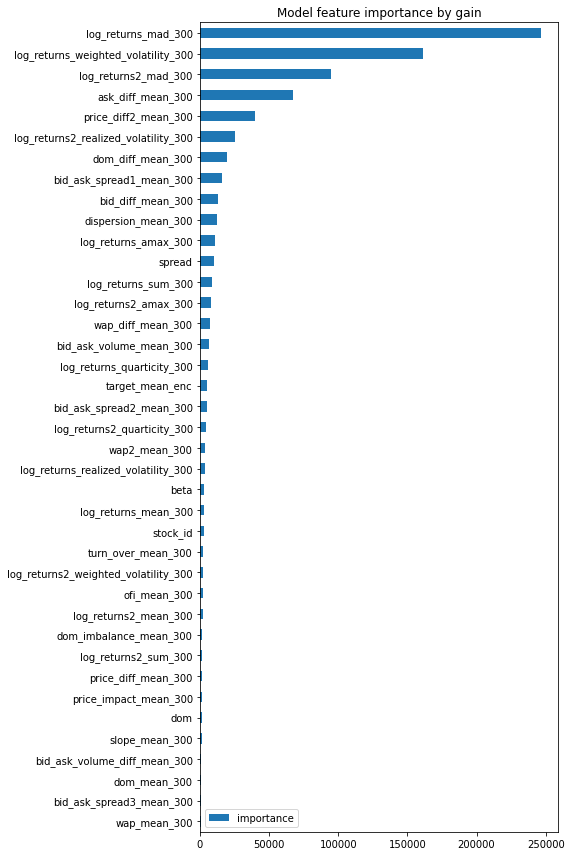

,feature_names,importance
0,wap_mean_300,839.384675
1,bid_ask_spread3_mean_300,1008.474001
2,dom_mean_300,1089.286184
3,bid_ask_volume_diff_mean_300,1149.514817
4,slope_mean_300,1238.354845
5,dom,1326.474790
6,price_impact_mean_300,1416.613091
7,price_diff_mean_300,1493.405552
8,log_returns2_sum_300,1664.130183
9,dom_imbalance_mean_300,1800.739414


In [19]:
mean_gain_df = compute_mean_importance(gain_importance)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('gain_importance_mean.csv', index=False)
    
mean_gain_df

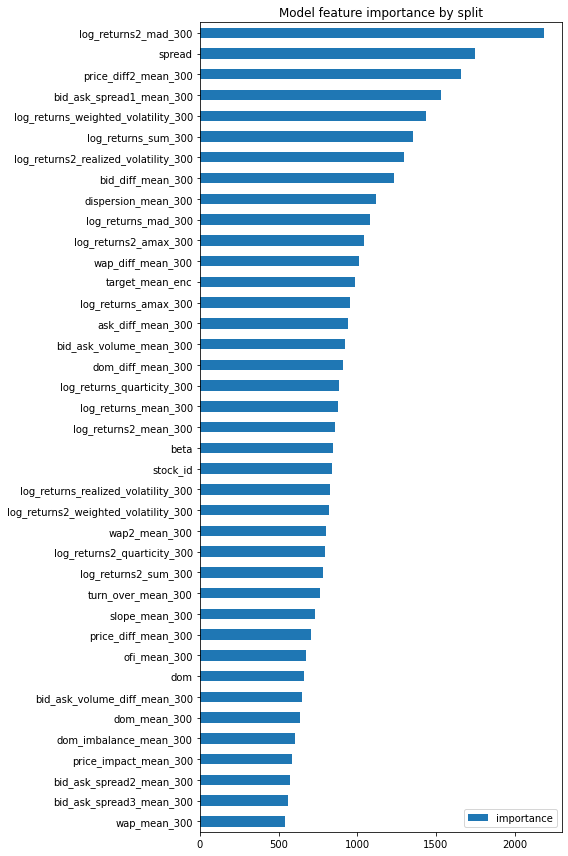

,feature_names,importance
0,wap_mean_300,544.28
1,bid_ask_spread3_mean_300,561.60
2,bid_ask_spread2_mean_300,571.40
3,price_impact_mean_300,587.96
4,dom_imbalance_mean_300,606.68
5,dom_mean_300,638.64
6,bid_ask_volume_diff_mean_300,651.08
7,dom,662.72
8,ofi_mean_300,675.12
9,price_diff_mean_300,703.80


In [20]:
mean_split_df = compute_mean_importance(split_importance)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('split_importance_mean.csv', index=False)

mean_split_df

## Test

In [21]:
y_test= df_test[['target_realized_volatility']]
X_test = df_test.drop(['time_id','target_realized_volatility'], axis = 1)

NameError: name 'df_test' is not defined

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
target = np.zeros(len(X_test))
scores = 0.0

# take mean of predictions for all models on test features 
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [ ]:
y_test = y_test.assign(predicted_volatility = target)
y_test

### Test Result

In [ ]:
RMSPE = round(rmspe(y_true=y_test['target_realized_volatility'], y_pred=y_test['predicted_volatility']), 4)

print(f'Performance RMSPE: {RMSPE}')

### Reference Paper: LightGBM Based Optiver Realized Volatility Prediction
#### Link:  https://ieeexplore-ieee-org.ezproxy.library.sydney.edu.au/document/9543438